In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np

import nibabel.nicom.dicomwrappers
from spec2nii.dicomfunctions import process_siemens_csi
import matplotlib.pyplot as plt

import datetime
import json

import nibabel as nib
import h5py

/Users/wclarke/opt/miniconda3/envs/fsl_mrs/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  


### Load the data
This is a single coil 3T31P dataset of a human brain.

In [2]:
dicom_file = Path('original_data/csi/Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA')

In [3]:
img = nibabel.nicom.dicomwrappers.wrapper_from_file(str(dicom_file))
           
specDataCmplx,currNiftiOrientation,dwelltime,meta = process_siemens_csi(img,{})

specDataCmplx = specDataCmplx.conj()

mainStr = img.dcm_data.SeriesDescription

print(f'Data description is "{mainStr}"')
print(f'Data size is {specDataCmplx.shape} (x,y,z,t)')
print(f'Data orientation affine is\n {currNiftiOrientation.Q44}')

Data description is "uteCsi Hamming 12x12x12 Long"
Data size is (16, 16, 16, 1024) (x,y,z,t)
Data orientation affine is
 [[ -14.375        -0.           -0.          124.01402378]
 [  -0.          -14.375        -0.          138.46439934]
 [   0.            0.           12.5        -101.46740484]
 [   0.            0.            0.            1.        ]]


#### Plot

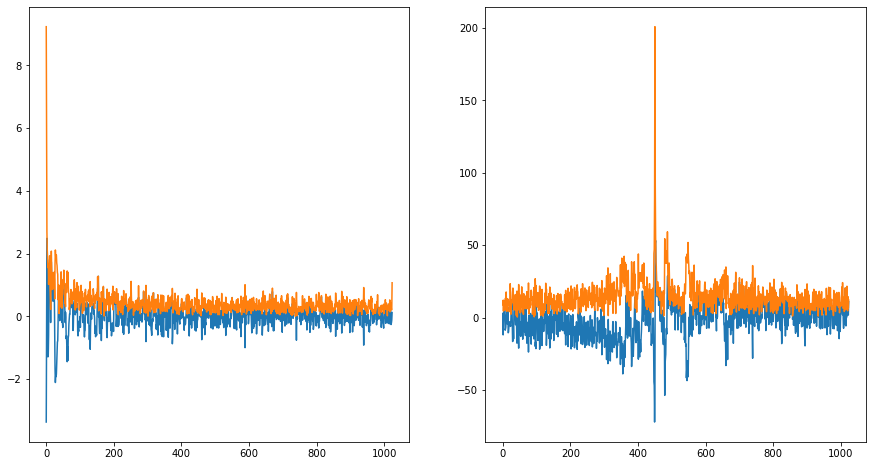

In [4]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
test_FID = specDataCmplx[7,7,10,:]
ax1.plot(np.real(test_FID))
# ax1.plot(np.imag(specDataCmplx[7,7,6,:]))
ax1.plot(np.abs(test_FID))

def spec_fft(x):
    x[0] *= 0.5;
    spec = np.fft.fftshift(np.fft.fft(x))
    x[0] *= 2;
    return spec

ax2.plot(np.real(spec_fft(test_FID)))
ax2.plot(np.abs(spec_fft(test_FID)))
plt.show()

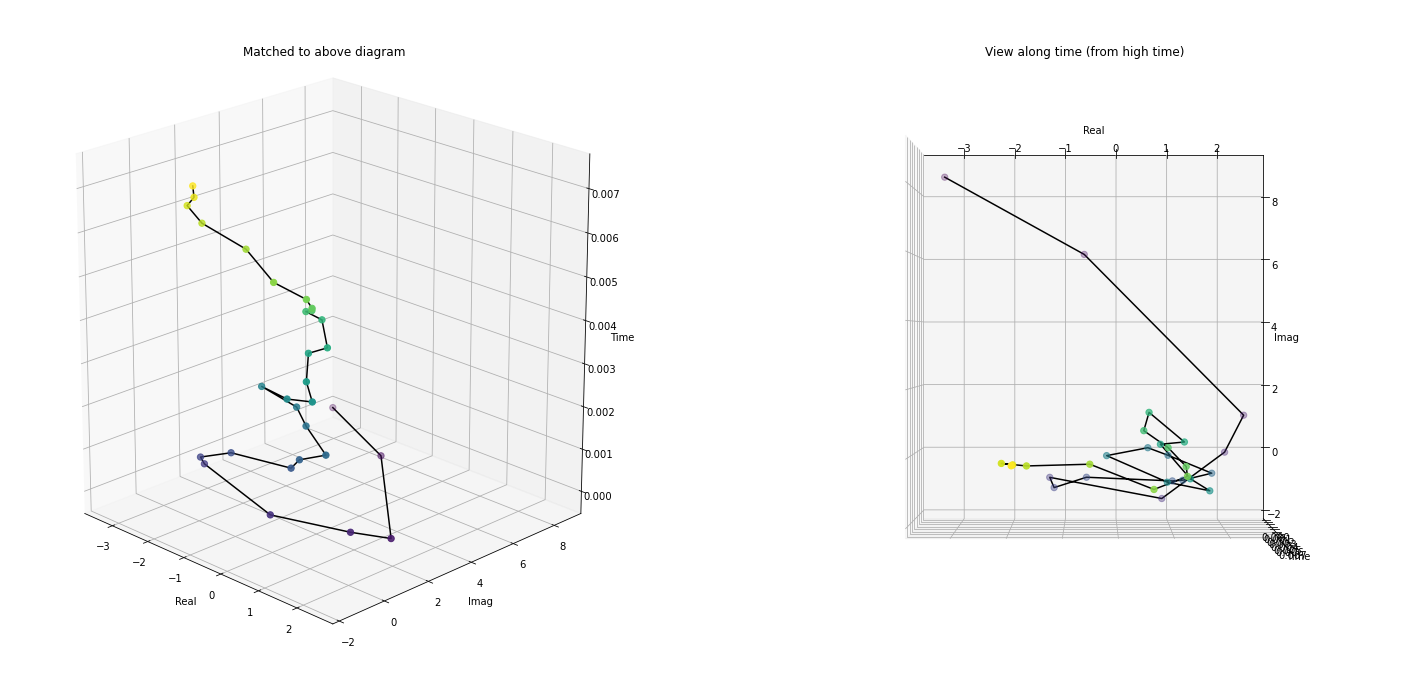

In [5]:
time_axis = dwelltime*np.arange(0,test_FID.size)
fig = plt.figure(figsize=(25,12.5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(20, -45)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Matched to above diagram')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(test_FID[:30]),np.imag(test_FID[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(90, -90)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('View along time (from high time)')
plt.show()

This appears to be the correct convention to match my definitions:
- The spectral data points are ordered in sequence of increasing time and contain the value TIME.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time):
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.

The dominant PCr peak is at a negative frequency compared to the reference on the absolute scale and appears to rotate in a negative (clockwise) sense.

### Voxel orientation calculations 
Have already been completed in the spec2nii code

### Meta data
#### Required for Level 0

In [6]:
level_0_dict = {}

#### Required for Level 1
**TransmitterFrequency** , Array of doubles, See DICOM tag (0018,9098). Should be given in MHz.  
**ResonantNucleus**, Array of strings, See DICOM tag (0018,9100). Must be one of the DICOM recognised nuclei “1H”, “3HE”, “7LI”, “13C”, “19F”, “23NA”, “31P”, “129XE” or one named in the specified format. I.e. Mass number followed by the chemical symbol in uppercase.  
**SpectralWidth**, Array of doubles, See DICOM tag (0018,9052). Should be given in Hz.  

In [7]:
dwelltime = meta['Dwelltime'] # For nifti pixel dim
spectral_width_hz = 1/dwelltime
transmitter_frequency_hz = meta['ImagingFrequency']
nucleus_str = meta['Nucleus'].strip('"')

print(f'TransmitterFrequency = {transmitter_frequency_hz:0.6f} Hz')
print(f'ResonantNucleus = {nucleus_str}')
print(f'SpectralWidth = {spectral_width_hz:0.2f} Hz')

TransmitterFrequency = 49.860130 Hz
ResonantNucleus = 31P
SpectralWidth = 4000.00 Hz


#### Extract some Level 2B parameters as well 

Incude:  
**EchoTime**, double, Time from centroid of excitation to start of FID or centre of echo. Units: Seconds  
**RepetitionTime**, double, Sequence repetition time. Units: Seconds  
**InversionTime**, double, Inversion time. Units: Seconds  
**MixingTime**, double, Mixing time in e.g. STEAM sequence. Units: Seconds


**ConversionMethod**, String, Program used for conversion. May include additional information like software version.  
**ConversionTime**, String:  “YYYY-MM-DDThh:mm:ss.sss”, Time and date of conversion. ISO 8601 compliant format  
**OriginalFile**, String, Name and extension of the original file  



Not included:  
**SaturationBands**, Array of 2D 4x4 arrays, Orientation/position affine for each saturation band

In [8]:
echo_time_s = meta['EchoTime']
repetition_time_s = meta['RepetitionTime']
inversion_time_s = meta['InversionTime']
mixing_time_s = None

print(f'EchoTime = {echo_time_s:0.3f} s')
print(f'RepetitionTime = {repetition_time_s:0.3f} s')
print(f'InversionTime = {inversion_time_s:0.3f} s')
print(f'MixingTime = {mixing_time_s} s')

conversion_method = 'Manual conversion in python'
conversion_time = datetime.datetime.now().strftime("%y%m%dT%H%M%S")
print(f'ConversionMethod = {conversion_method}')
print(f'ConversionTime = {conversion_time}')
print(f'OriginalFile = {dicom_file.name}') # How to handle multiple files???


EchoTime = 0.002 s
RepetitionTime = 1.000 s
InversionTime = 0.000 s
MixingTime = None s
ConversionMethod = Manual conversion in python
ConversionTime = 201015T155541
OriginalFile = Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA


## Make the json string

In [9]:
level_1_dict = {**level_0_dict,
                'TransmitterFrequency':transmitter_frequency_hz,
                'ResonantNucleus':nucleus_str,
                'SpectralWidth':spectral_width_hz}

json_lvl_1 = json.dumps(level_1_dict)
print(json_lvl_1)

level_2_dict = {**level_1_dict,
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime':conversion_time,
                'OriginalFile':dicom_file.name}

json_lvl_2 = json.dumps(level_2_dict)
print(json_lvl_2)


{"TransmitterFrequency": 49.86013, "ResonantNucleus": "31P", "SpectralWidth": 4000.0}
{"TransmitterFrequency": 49.86013, "ResonantNucleus": "31P", "SpectralWidth": 4000.0, "EchoTime": 0.0023, "RepetitionTime": 1.0, "InversionTime": 0.0, "MixingTime": null, "ConversionMethod": "Manual conversion in python", "ConversionTime": "201015T155541", "OriginalFile": "Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA"}


### Write NIFTI file 

In [10]:
save_path = Path('./example_data/csi_1')
newobj = nib.nifti2.Nifti2Image(specDataCmplx,currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set conformance level 
newobj.header['intent_name'] = b'mrs_level_3'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_lvl_2.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'csi.nii.gz')

### Write JSON

In [11]:
with open(save_path / 'csi.json', 'w') as json_file:
        json.dump(level_2_dict, json_file)

## Write hdf5 to check against

In [12]:
with h5py.File(save_path / 'data.h5', 'w') as h5f:
    h5f.create_dataset('csi', data=specDataCmplx)

## Load and check

In [13]:
check_nifti = nib.load(save_path / 'csi.nii.gz')

with h5py.File(save_path / 'data.h5','r') as h5f:
    check_hdf5 = h5f['csi'][:]
    
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),specDataCmplx)
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),check_hdf5)

loaded_he_content = json.loads(check_nifti.header.extensions[0].get_content())

with open(save_path / 'csi.json', 'r') as json_file:
    loaded_he_content_from_json = json.loads(json_file.read())

assert loaded_he_content == level_2_dict
assert loaded_he_content_from_json == level_2_dict
